# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
plt.style.use('ggplot')
import astropy.units as u
import astropy.constants as const
import ipywidgets as widgets
import ipywidgets
from IPython.display import clear_output

import utils
from kernel_nuller import KN0

# System definition

In [2]:
kn0 = KN0(
    shifters_offset=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    input_phase_rms=1,
    inner_phase_rms=1
)

star_light = np.array([
    np.exp(0j),
    np.exp(0j),
    np.exp(0j),
    np.exp(0j),
], dtype=complex)

contrast = 1e-1
planet_light = np.array([
    contrast * np.exp(1j * 0.10),
    contrast * np.exp(1j * -0.12),
    contrast * np.exp(1j * 0.05),
    contrast * np.exp(1j * -0.01),
], dtype=complex)

# Manual shift controls

In [3]:
max_power = 1
step = 1e-20

# Build sliders
P_sliders = [widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description=f"P{i+1}") for i in range(14)]

bright, darks, intermediate = kn0(star_light)

def beam_repr(beam:complex) -> str:
    return f"{np.abs(beam):.3e} * exp({np.angle(beam)/np.pi:.3e} pi i)"   

inputs = [widgets.Label(value=f" ") for _ in range(4)]
first_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
second_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
outputs = [widgets.Label(value=f" ") for _ in range(7)]

def update_gui(*args):

    kn0.shift_powers = np.array([x.value for x in P_sliders])

    bright, darks, inter = kn0(star_light)

    for i, beam in enumerate(inter['inputs']):
        inputs[i].value = f"Input {i+1}: {beam_repr(beam)}"

    for i, beam in enumerate(inter['first_nuller_layer']):
        first_nuller_layer[i].value = f"N{i//2+1} : {i%2}: {beam_repr(beam)}"

    for i, beam in enumerate(inter['second_nuller_layer']):
        second_nuller_layer[i].value = f"N{i//2+3} : {i%2}: {beam_repr(beam)}"

    outputs[0].value = f"Bright : {beam_repr(bright)}"
    for i, beam in enumerate(darks): 
        outputs[i+1].value = f"Dark {i+1}: {beam_repr(beam)}"

    return bright, darks


for widget in P_sliders:
    widget.observe(update_gui, 'value')

empty = widgets.Label()

vbox = widgets.VBox([
    *[widgets.HBox([x]) for x in inputs],

    widgets.Label("1st nuller layer phase corrective powers:"),
    widgets.HBox(P_sliders[:4]),

    *[widgets.HBox([x]) for x in first_nuller_layer],

    widgets.Label("2nd nuller layer phase corrective powers:"),
    widgets.HBox(P_sliders[4:8]),
    
    *[widgets.HBox([x]) for x in second_nuller_layer],

    widgets.Label("Split & Mix phase corrective powers:"),
    widgets.HBox(P_sliders[8:11]),
    widgets.HBox(P_sliders[11:14]),

    *[widgets.HBox([x]) for x in outputs],
])

update_gui()
vbox

# System optimization

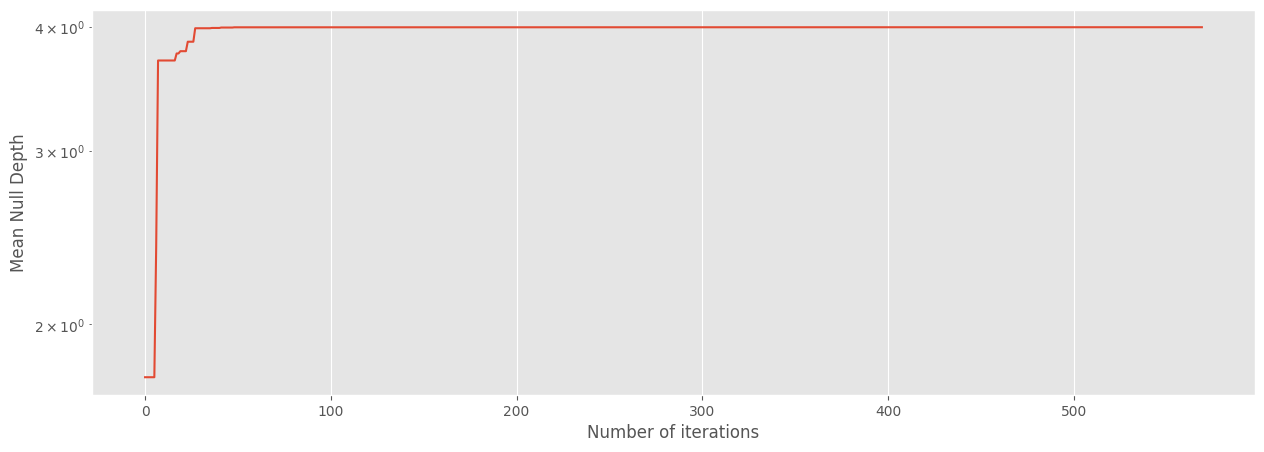

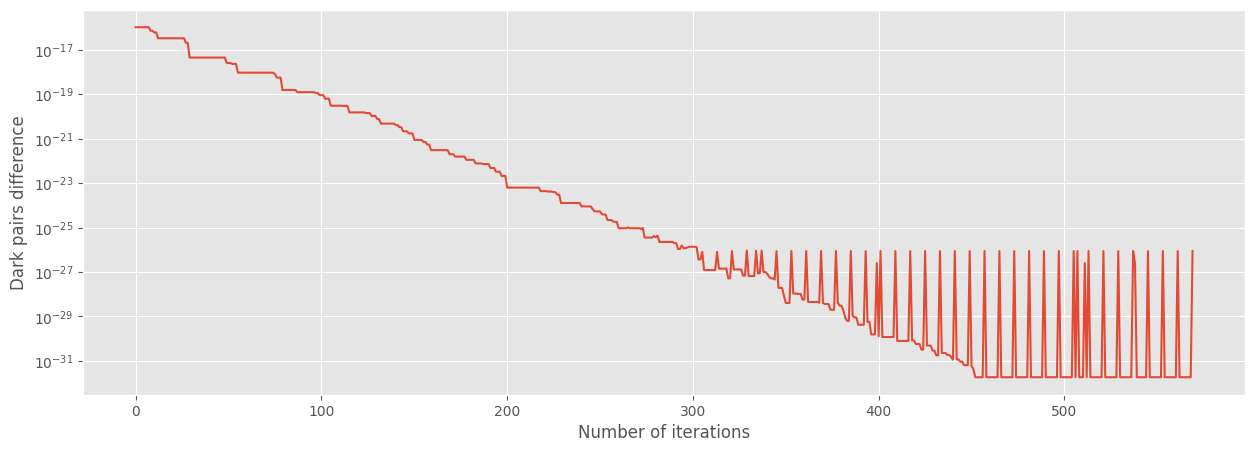

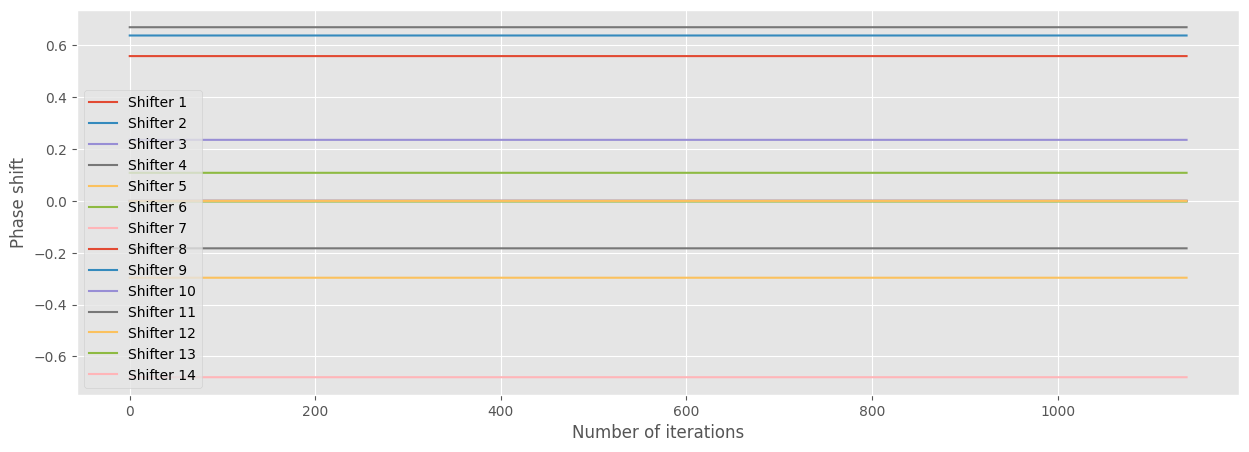

Optimized parameters | Introduced error
P1 = 0.00e+00 | 0.00e+00
P2 = 6.38e-01 | -6.38e-01
P3 = 2.36e-01 | 1.17e+00
P4 = -1.83e-01 | -4.10e-01
P5 = -2.96e-01 | 7.50e-01
P6 = -2.27e-03 | -8.12e-02
P7 = -1.72e-10 | 1.05e+00
P8 = 5.59e-01 | -1.68e-01
P9 = 0.00e+00 | 8.10e-01
P10 = 0.00e+00 | 5.30e-01
P11 = 6.70e-01 | -2.93e-01
P12 = 0.00e+00 | 1.19e+00
P13 = 1.08e-01 | -1.03e-01
P14 = -6.80e-01 | 7.80e-01


In [4]:
optimized_parameters, history = kn0.optimize(star_light, verbose=False)

bright_evol, dark_symmetry_evol, shifts_evol = history["bright"], history["symmetry"], history["shifters"]

plt.figure(figsize=(15, 5))
plt.plot(bright_evol)
plt.xlabel("Number of iterations")
plt.ylabel("Mean Null Depth")
plt.yscale("log")
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(dark_symmetry_evol)
plt.xlabel("Number of iterations")
plt.ylabel("Dark pairs difference")
plt.yscale("log")
plt.show()

plt.figure(figsize=(15, 5))
for i in range(len(kn0.shift_powers)):
    plt.plot(shifts_evol[:,i], label=f"Shifter {i+1}")
plt.xlabel("Number of iterations")
plt.ylabel("Phase shift")
plt.yscale("linear")
plt.legend()
plt.show()

# Ignoring global phase
introduced_error = kn0.shifters_noise + kn0.shifters_offset
# introduced_error -= introduced_error[0]
# optimized_parameters -= optimized_parameters[0]
optimized_parameters = utils.bound_phase(optimized_parameters)

print("Optimized parameters | Introduced error")
for i in range(14):
    print(f"P{i+1} = {optimized_parameters[i] - optimized_parameters[0]:.2e} | {introduced_error[i] - introduced_error[0]:.2e}")

# Cheat code :
optimized_parameters = -introduced_error

# Shifters correlation

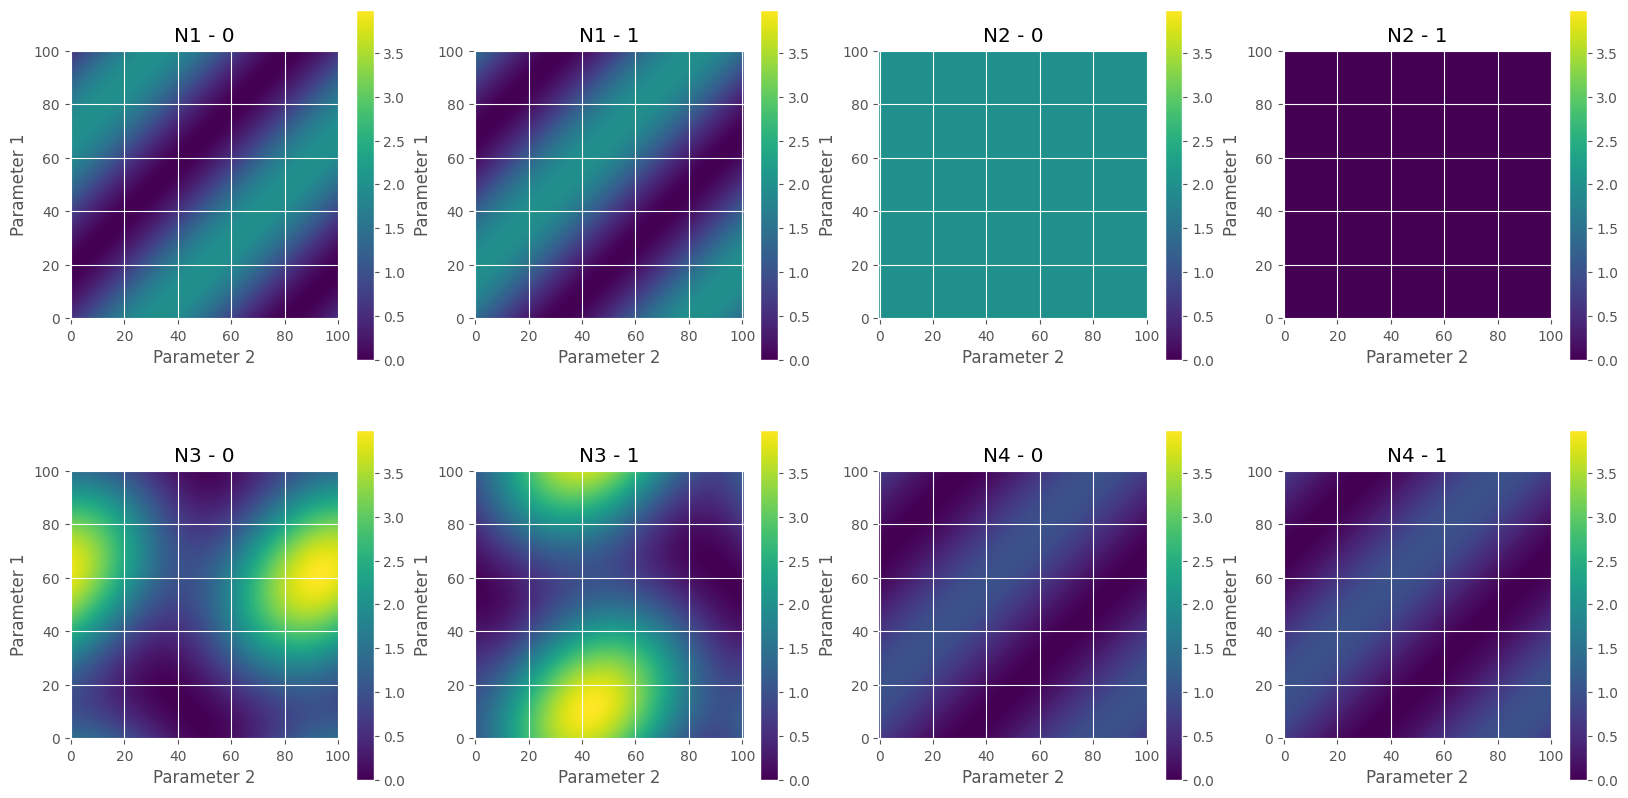

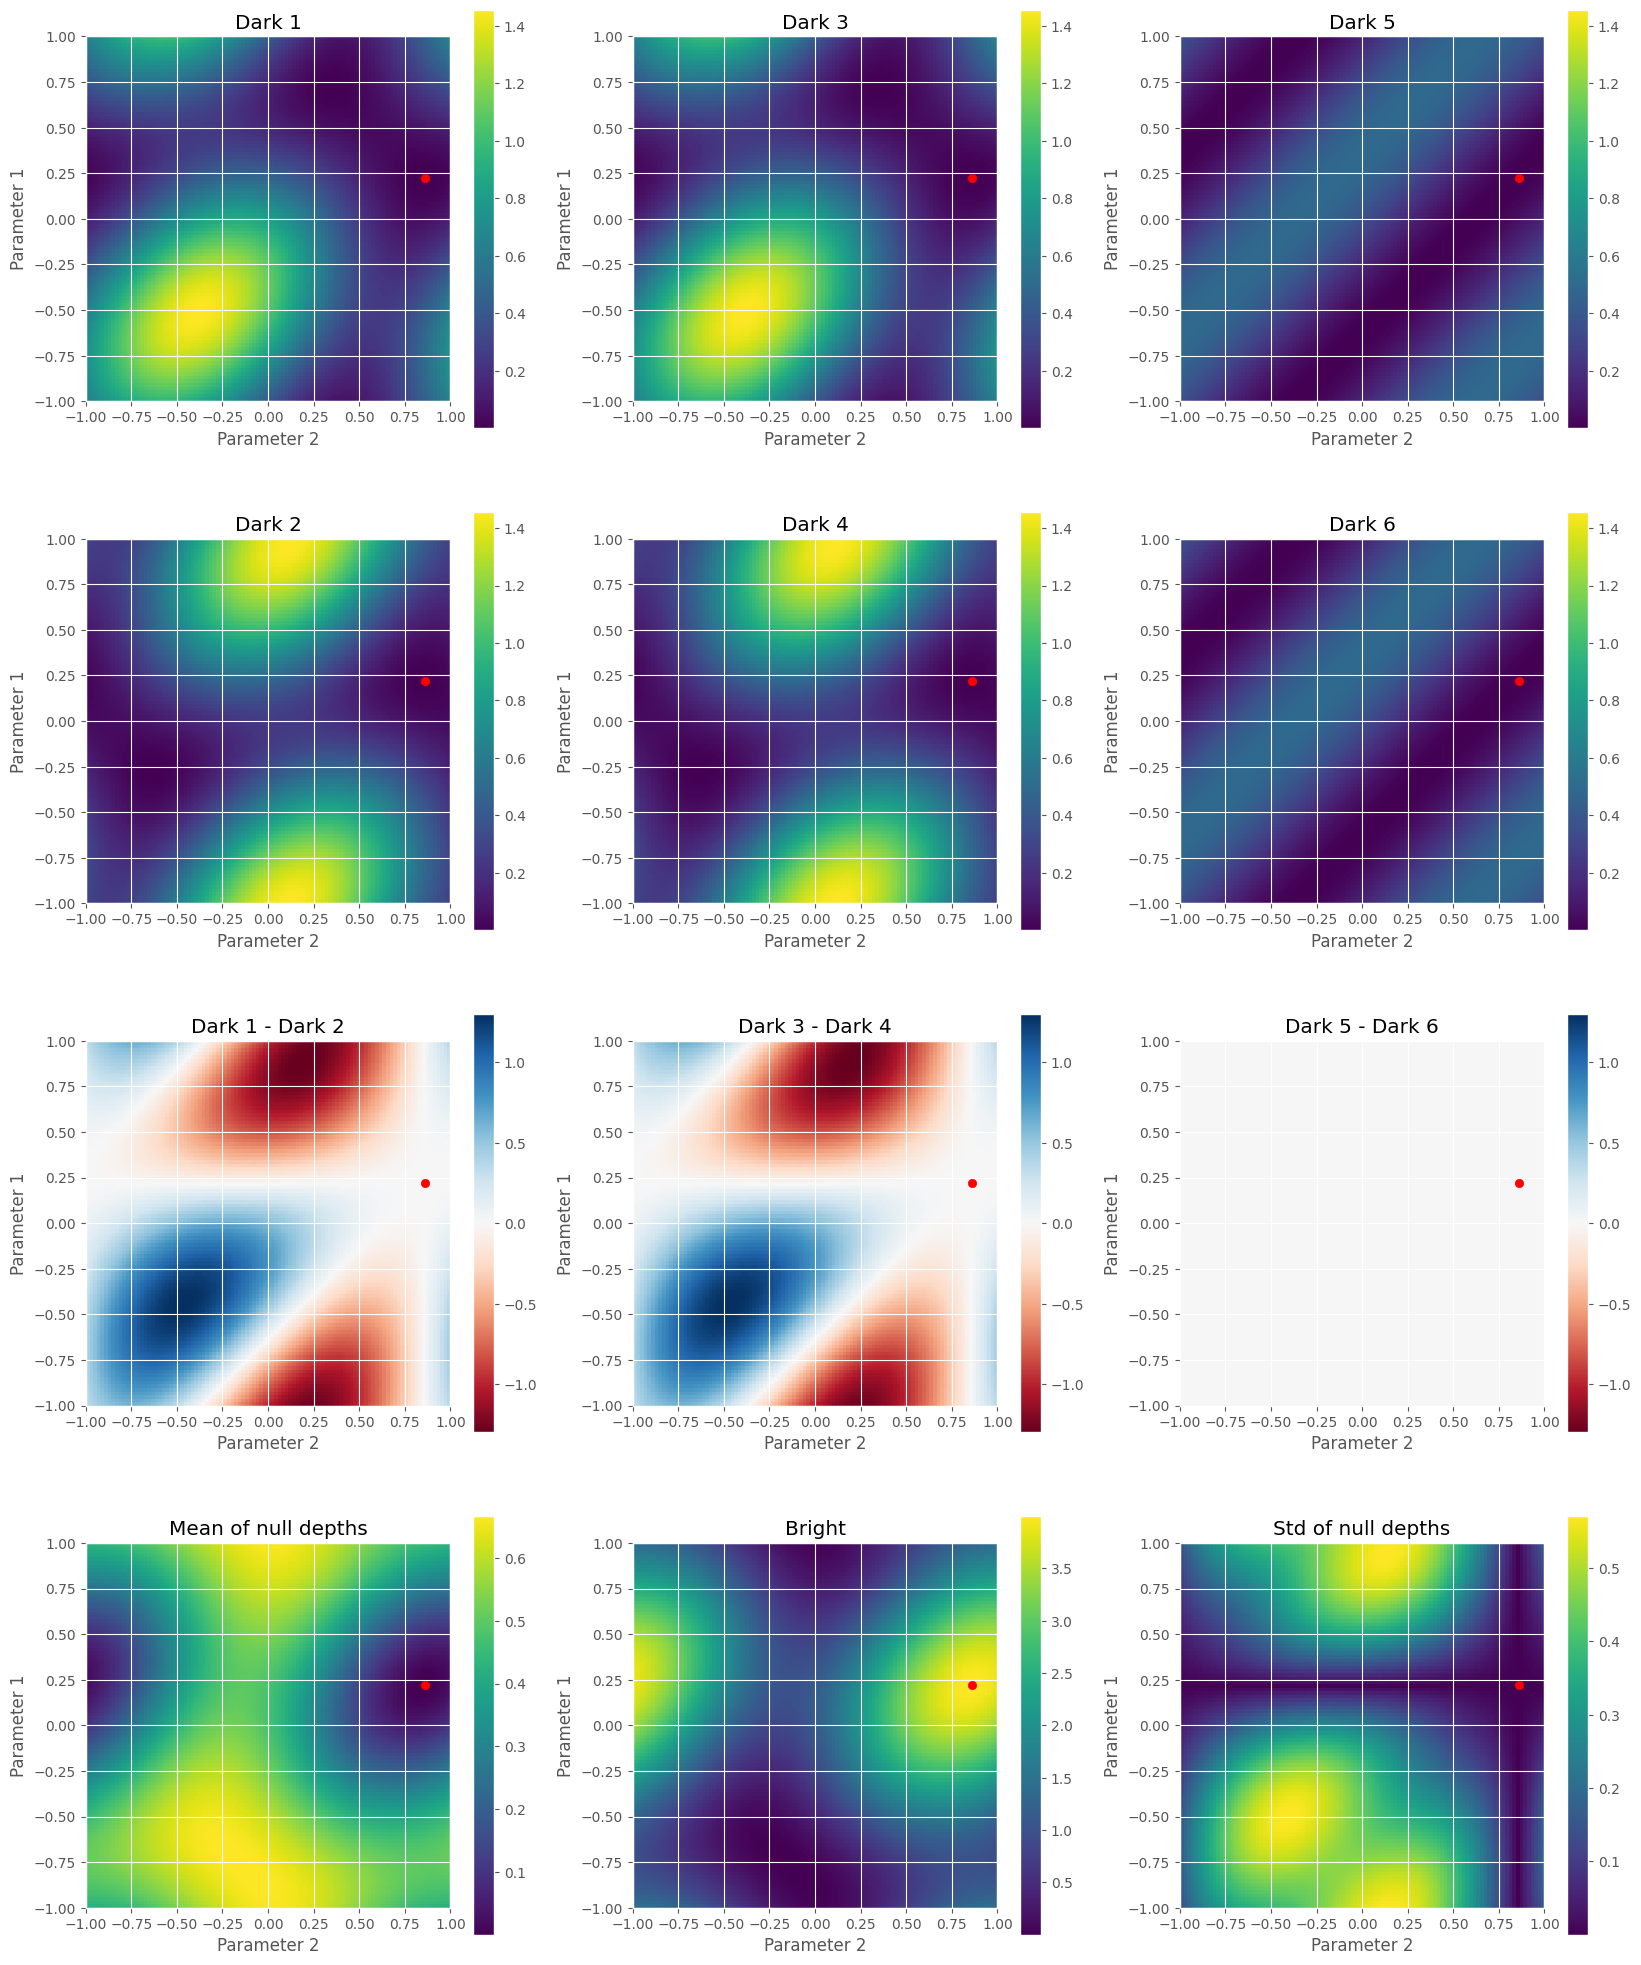

In [5]:
utils.scan(
    kn=kn0, 
    beams=star_light,
    scan_on=(1,2),
    initial_parameters=optimized_parameters,#-introduced_error,
    optimized_parameters=optimized_parameters,
    plot_intermediate_states=True
)

# Simulation & analysis

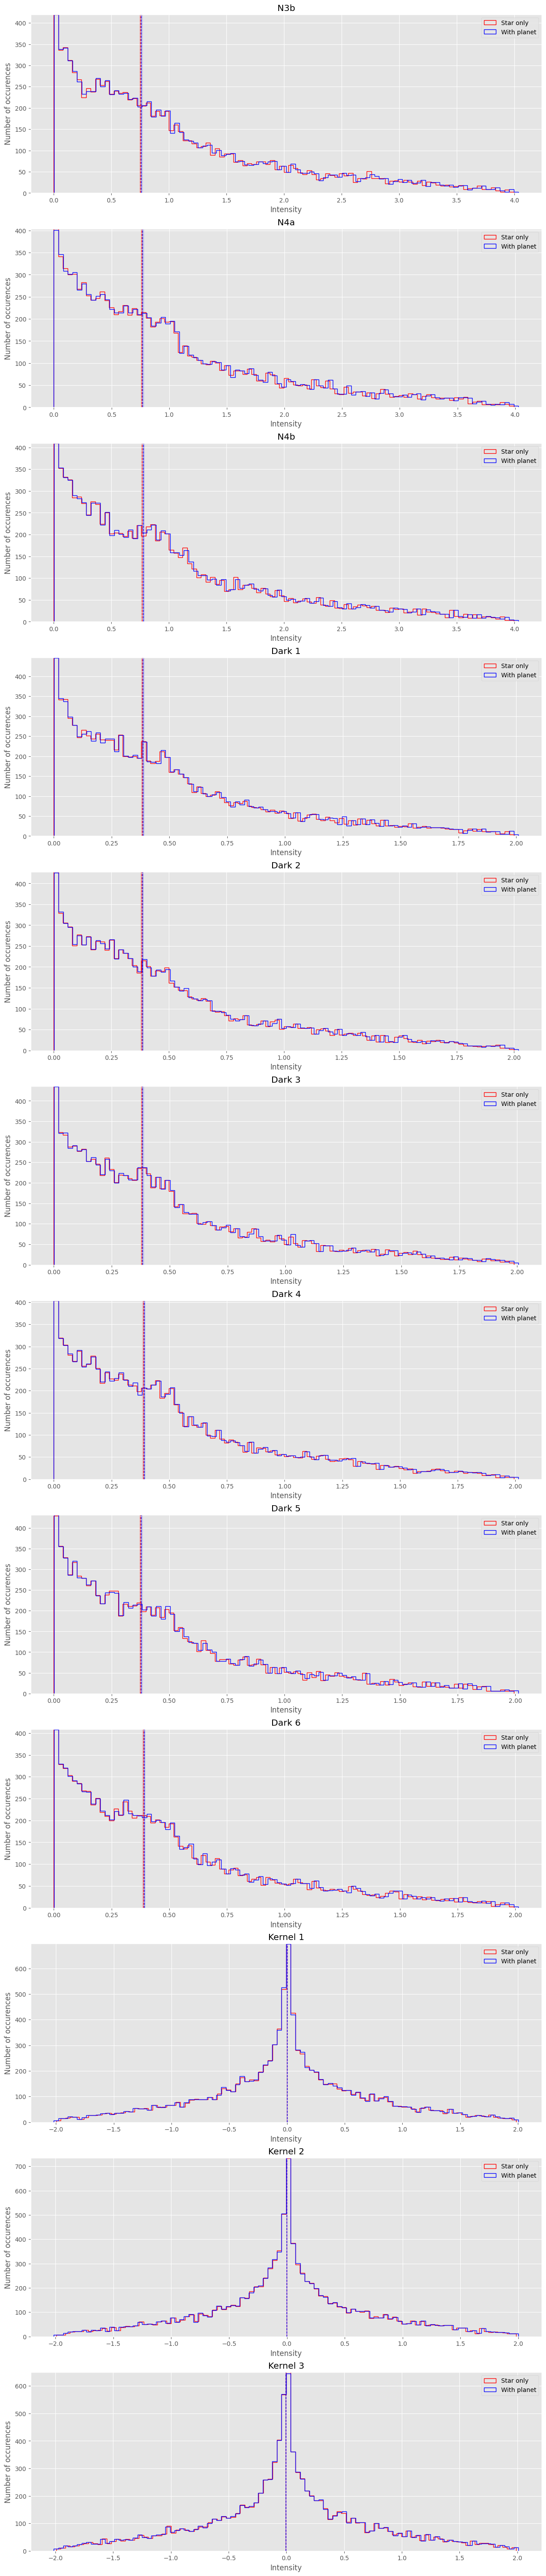

In [6]:

# Simulations -----------------------------------------------------------------

N = 10000

null_star_only = [[],[],[]]
null_with_planet = [[],[],[]]
null_outputs = ['N3b', 'N4a', 'N4b']
dark_star_only = [[],[],[],[],[],[]]
dark_with_planet = [[],[],[],[],[],[]]
kernel_star_only = [[],[],[]]
kernel_with_planet =  [[],[],[]]

for i in range(N):
    kn0.noise_input_shifters()

    # Star only ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    _, darks_star_only, inter_star_only = kn0(star_light, optimized_parameters)

    current_null_star_only = np.abs([
        inter_star_only["second_nuller_layer"][1],
        inter_star_only["second_nuller_layer"][2],
        inter_star_only["second_nuller_layer"][3]
    ])**2
    for j in range(3):
        null_star_only[j].append(current_null_star_only[j])
    
    current_dark_star_only = np.abs(darks_star_only)**2
    for j in range(6):
        dark_star_only[j].append(current_dark_star_only[j])

    for j in range(3):
        kernel_star_only[j].append(current_dark_star_only[2*j] - current_dark_star_only[2*j+1])

    # With planet ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    _, darks_with_planet, inter_with_planet = kn0(planet_light, optimized_parameters)

    current_null_with_planet = np.abs([
        inter_with_planet["second_nuller_layer"][1],
        inter_with_planet["second_nuller_layer"][2],
        inter_with_planet["second_nuller_layer"][3]
    ])**2 + current_null_star_only
    for j in range(3):
        null_with_planet[j].append(current_null_with_planet[j])

    current_dark_with_planet = np.abs(darks_with_planet)**2 + current_dark_star_only
    for j in range(6):
        dark_with_planet[j].append(current_dark_with_planet[j])

    for j in range(3):
        kernel_with_planet[j].append(current_dark_with_planet[2*j] - current_dark_with_planet[2*j+1])

# Analysis --------------------------------------------------------------------

# Estimation ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

estimator = np.median

mean_null_star_only =  [[],[],[]]
mean_null_with_planet =  [[],[],[]]
for j in range(3):
    mean_null_star_only[j] = estimator(null_star_only[j])
    mean_null_with_planet[j] = estimator(null_with_planet[j])

mean_dark_star_only =  [[],[],[],[],[],[]]
mean_dark_with_planet =  [[],[],[],[],[],[]]
for j in range(6):
    mean_dark_star_only[j] = estimator(dark_star_only[j])
    mean_dark_with_planet[j] = estimator(dark_with_planet[j])

mean_kernel_star_only =  [[],[],[]]
mean_kernel_with_planet =  [[],[],[]]
for j in range(3):
    mean_kernel_star_only[j] = estimator(kernel_star_only[j])
    mean_kernel_with_planet[j] = estimator(kernel_with_planet[j])

# Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def bootstrap(data, N=1000, estimator=np.median):
    return np.std([estimator(np.array(data)[np.random.randint(0, len(data), size=len(data))]) for _ in range(N)])

std_null_star_only =  [[],[],[],[],[]]
std_null_with_planet =  [[],[],[],[],[]]
for j in range(3):
    std_null_star_only[j] = bootstrap(null_star_only[j])
    std_null_with_planet[j] = bootstrap(null_with_planet[j])

std_dark_star_only =  [[],[],[],[],[],[]]
std_dark_with_planet =  [[],[],[],[],[],[]]
for j in range(6):
    std_dark_star_only[j] = bootstrap(dark_star_only[j])
    std_dark_with_planet[j] = bootstrap(dark_with_planet[j])

std_kernel_star_only =  [[],[],[]]
std_kernel_with_planet =  [[],[],[]]
for j in range(3):
    std_kernel_star_only[j] = bootstrap(kernel_star_only[j])
    std_kernel_with_planet[j] = bootstrap(kernel_with_planet[j])

# Plots -----------------------------------------------------------------------

fig, axs = plt.subplots(12, 1, figsize=(15, 75))
bins = 100

# Nuller ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for i in range(3):
    ax = axs[i]

    # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    n1,_,_ = ax.hist(null_star_only[i], bins=bins, histtype='step', color='red', label=f"Star only", linewidth=1)
    n2,_,_ = ax.hist(np.array(null_with_planet[i]), bins=bins, histtype='step', color='blue', label=f"With planet", linewidth=1)
    m = max(max(n1), max(n2))
    ax.set_ylim(0, m)

    # Estimated value ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    ax.set_xlabel("Intensity")
    ax.set_ylabel("Number of occurences")
    ax.axvline(mean_null_star_only[i], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(mean_null_with_planet[i], color='blue', linestyle='dashed', linewidth=1)

    # Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot std as filled area
    ax.fill_betweenx([0, m], mean_null_star_only[i]-std_null_star_only[i], mean_null_star_only[i]+std_null_star_only[i], color='red', alpha=0.1)
    ax.fill_betweenx([0, m], mean_null_with_planet[i]-std_null_with_planet[i], mean_null_with_planet[i]+std_null_with_planet[i], color='blue', alpha=0.1)

    ax.set_title(f"{null_outputs[i]}")
    ax.legend()

# Dark ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
for i in range(6):
    ax = axs[i+3]

    # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    n1,_,_ = ax.hist(dark_star_only[i], bins=bins, histtype='step', color='red', label=f"Star only", linewidth=1)
    n2,_,_ = ax.hist(np.array(dark_with_planet[i]), bins=bins, histtype='step', color='blue', label=f"With planet", linewidth=1)
    m = max(max(n1), max(n2))
    ax.set_ylim(0, m)

    # Estimated value ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    ax.set_xlabel("Intensity")
    ax.set_ylabel("Number of occurences")
    ax.axvline(mean_dark_star_only[i], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(mean_dark_with_planet[i], color='blue', linestyle='dashed', linewidth=1)

    # Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot std as filled area
    ax.fill_betweenx([0, m], mean_dark_star_only[i]-std_dark_star_only[i], mean_dark_star_only[i]+std_dark_star_only[i], color='red', alpha=0.1)
    ax.fill_betweenx([0, m], mean_dark_with_planet[i]-std_dark_with_planet[i], mean_dark_with_planet[i]+std_dark_with_planet[i], color='blue', alpha=0.1)

    ax.set_title(f"Dark {i+1}")
    ax.legend()

# Kernel ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for i in range(3):
    ax = axs[i+9]

    # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    n1,_,_ = ax.hist(kernel_star_only[i], bins=bins, histtype='step', color='red', label=f"Star only", linewidth=1)
    n2,_,_ = ax.hist(np.array(kernel_with_planet[i]), bins=bins, histtype='step', color='blue', label=f"With planet", linewidth=1)
    m = max(max(n1), max(n2))
    ax.set_ylim(0, m)

    # Estimated value ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    ax.set_xlabel("Intensity")
    ax.set_ylabel("Number of occurences")
    ax.axvline(mean_kernel_star_only[i], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(mean_kernel_with_planet[i], color='blue', linestyle='dashed', linewidth=1)

    # Std of the estimator ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot std as filled area
    ax.fill_betweenx([0, m], mean_kernel_star_only[i]-std_kernel_star_only[i], mean_kernel_star_only[i]+std_kernel_star_only[i], color='red', alpha=0.1)
    ax.fill_betweenx([0, m], mean_kernel_with_planet[i]-std_kernel_with_planet[i], mean_kernel_with_planet[i]+std_kernel_with_planet[i], color='blue', alpha=0.1)

    ax.set_title(f"Kernel {i+1}")
    ax.legend()

plt.show()